### Questions:
* Fiducial mark should take as value value from original signal or from integrated and filtered?
Check it agains paper - what value should fifucial mark represent?
* How to reduce detection delay keeping good detection level?
* How should detector behave when it gets totally scattered signal? Should it try to detect some peaks? Or maybe it is better to give nothing and avoid false positives?
* Shoud signal be normalized after every processing step

### Tuning:
* Change spki and npki exponential filter params.
* Threshold 1 is too little reactive on disturbances in raw signal - make it easier to qualify peak as noise (e.g. pulse17.csv).
* After threshold 1 key importance is fiducial mark (peak) detection in integrated signal. Test how does it work (how much does it detect) for different datasets.
* After that there is differentiation parameters.
* Signal filtration optimization.
* spki, npki, threshold1 and threshold2 init.

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt

In [24]:
## Signal filtering methods.
def butter_bandpass(lowcut, highcut, signal_freq, order=5):
    nyquist_freq = 0.5 * signal_freq
    low = lowcut / nyquist_freq
    high = highcut / nyquist_freq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, signal_freq, order=5):
    b, a = butter_bandpass(lowcut, highcut, signal_freq, order=order)
    y = lfilter(b, a, data)
    return y

In [25]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

(0.0, 343.0, 1.1094819306999999, 3.4506354331)

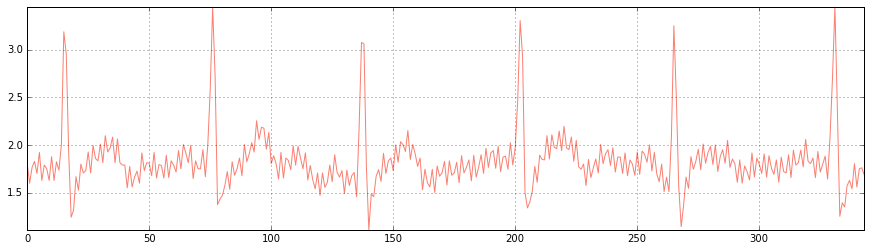

In [26]:
## Load and clean data.
with open("data/pulse1.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))
# raw_signal = raw_signal / max(raw_signal)

plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 343.0, -0.85351142278080483, 1.0254174672234138)

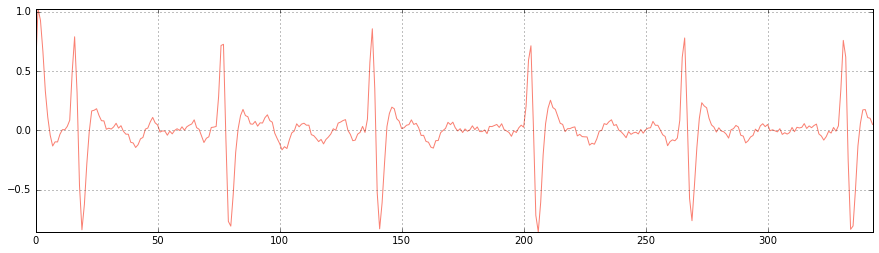

In [27]:
## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)
# bandpass_signal = bandpass_signal / max(bandpass_signal)

plt.figure(figsize=(15,4))
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 342.0, -0.87681089486291952, 0.52957354699356085)

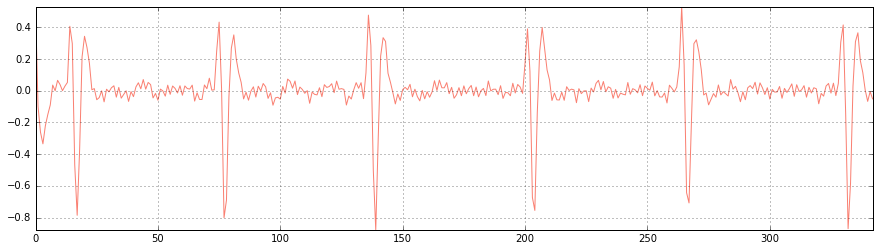

In [28]:
## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)
# differentiated_signal = differentiated_signal / max(differentiated_signal)

plt.figure(figsize=(15,4))
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 342.0, 5.5017964820888364e-10, 0.76879734535031374)

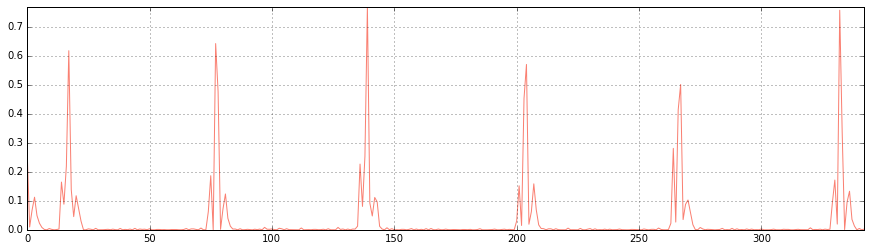

In [29]:
## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)
# squared_signal = squared_signal / max(squared_signal)

plt.figure(figsize=(15,4))
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 353.0, 0.00022212446468415338, 0.14223810522994307)

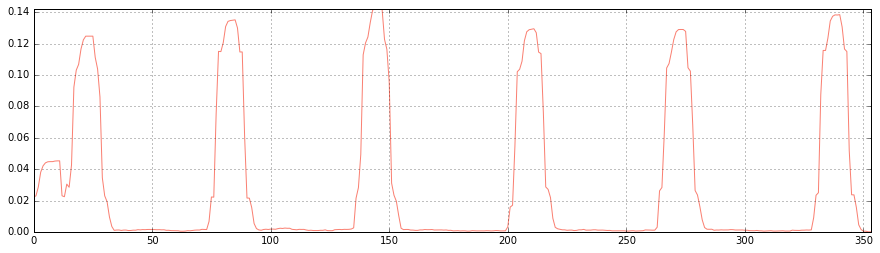

In [30]:
## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)
# integrated_signal = integrated_signal / max(integrated_signal) 

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

(0.0, 353.0, 0.0, 0.14223810522994307)

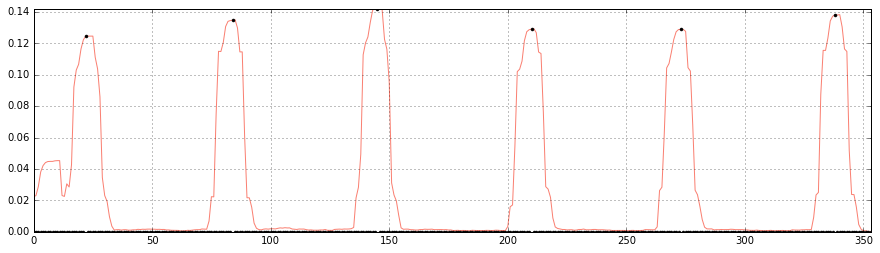

In [31]:
## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

plt.figure(figsize=(15,4))
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

In [32]:
## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
        print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
        print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

pulse - peak: 0.124706, spki: 0.015588, threshold1: 0.000000
pulse - peak: 0.134859, spki: 0.030497, threshold1: 0.003897
pulse - peak: 0.142238, spki: 0.044465, threshold1: 0.007624
pulse - peak: 0.129125, spki: 0.055047, threshold1: 0.011116
pulse - peak: 0.128955, spki: 0.064286, threshold1: 0.013762
pulse - peak: 0.138242, spki: 0.073530, threshold1: 0.016071


(0.0, 5.0, 0.0, 0.073530315261773421)

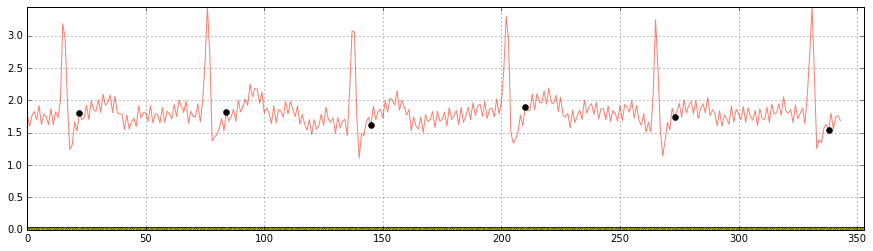

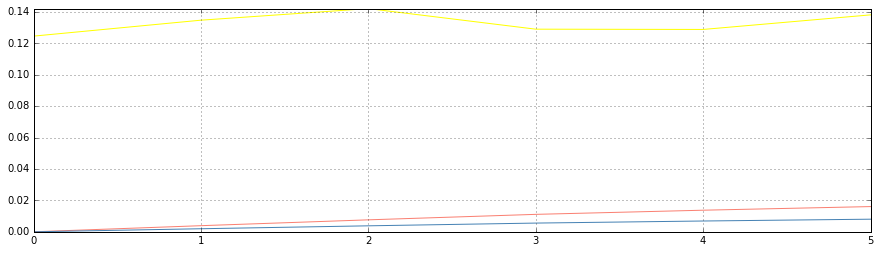

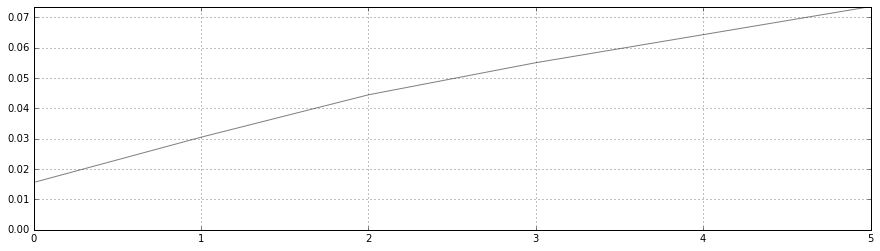

In [38]:
qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]
    
plt.figure(figsize=(15,4))
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")

plt.figure(figsize=(15,4))
plt.plot(threshold_1_vals, color="salmon", label='Threshold 1')
plt.plot(threshold_2_vals, color="steelblue", label='Threshold 2')
plt.plot(peak_vals, color="yellow", label='Peak')
plt.grid(True)
plt.axis('tight')

plt.figure(figsize=(15,4))
plt.plot(spki_vals, color="grey", label='Spki')
plt.plot(npki_vals, color="steelblue", label='Npki')
plt.grid(True)
plt.axis('tight')

(0.0, 353.0, 0.0, 3.4506354331)

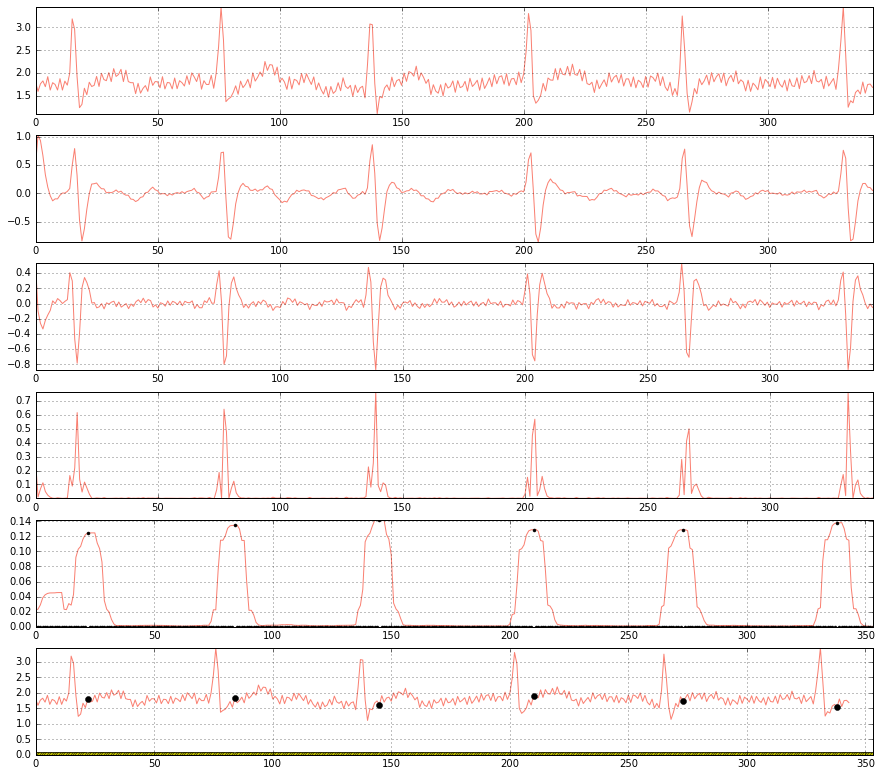

In [34]:
## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 1322.0, 0.0, 3.739002943)

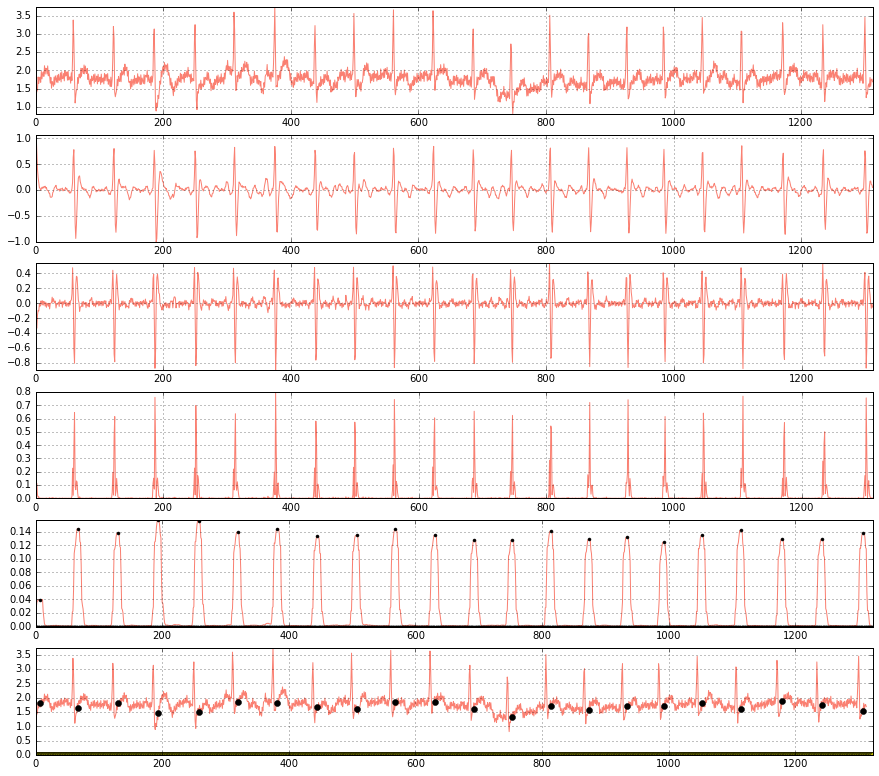

In [13]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse2.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 2731.0, 0.0, 3.739002943)

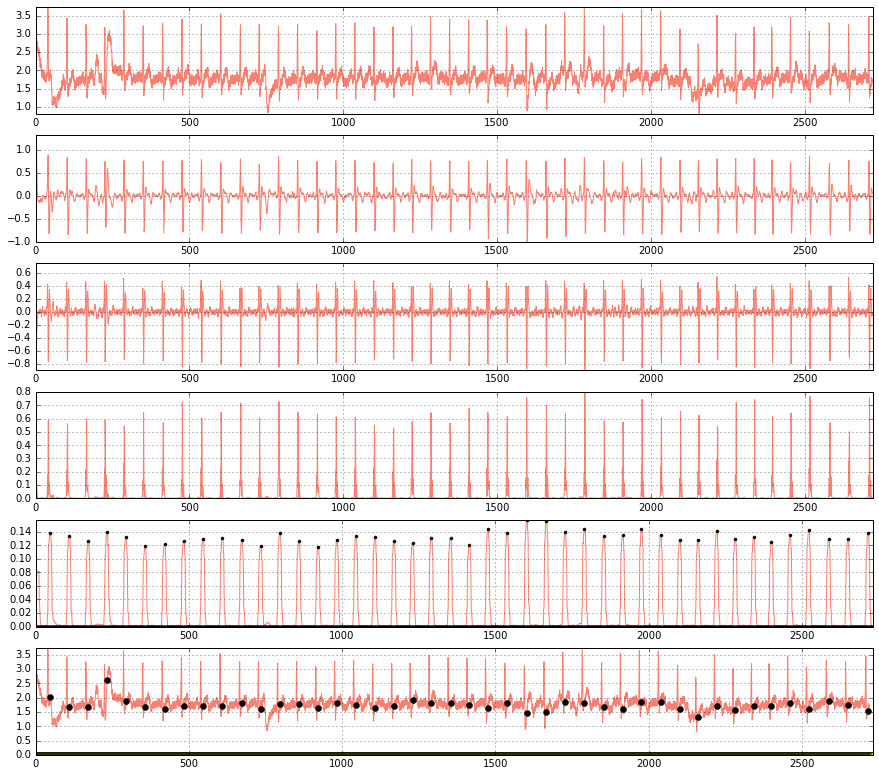

In [14]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse3.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 6678.0, 0.0, 4.6480937003999996)

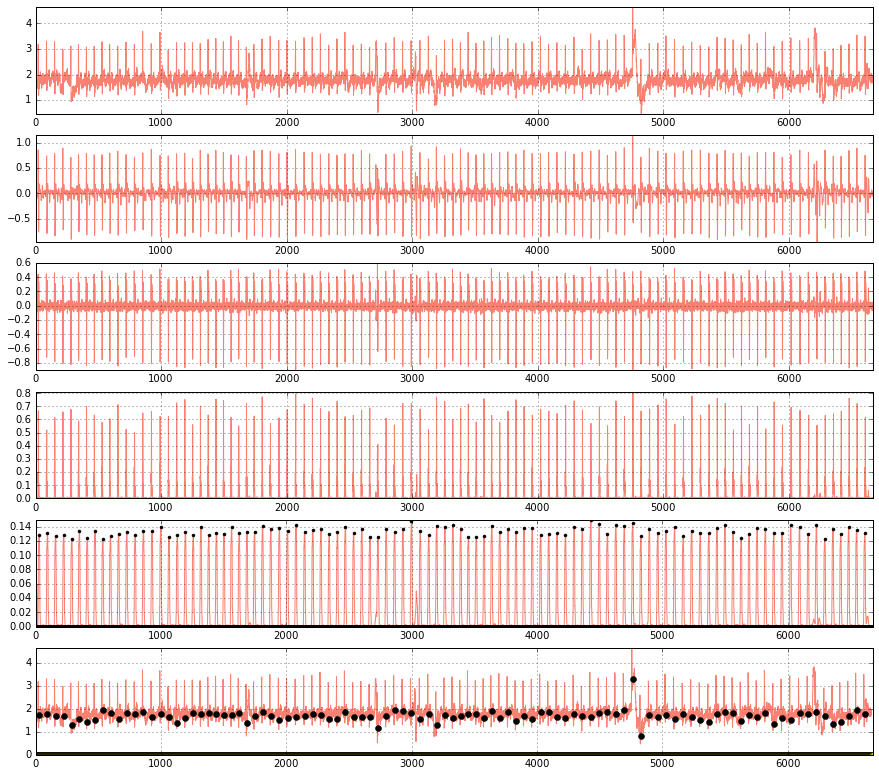

In [15]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse5.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 701.0, 0.0, 4.3548388481)

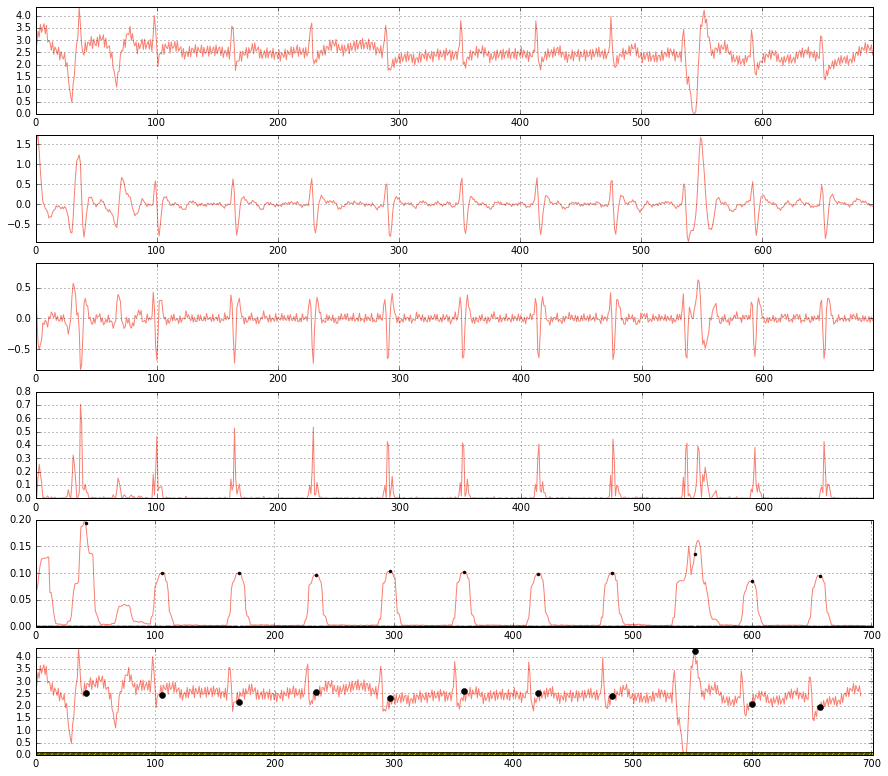

In [16]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse6.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 5076.0, 0.0, 5.0)

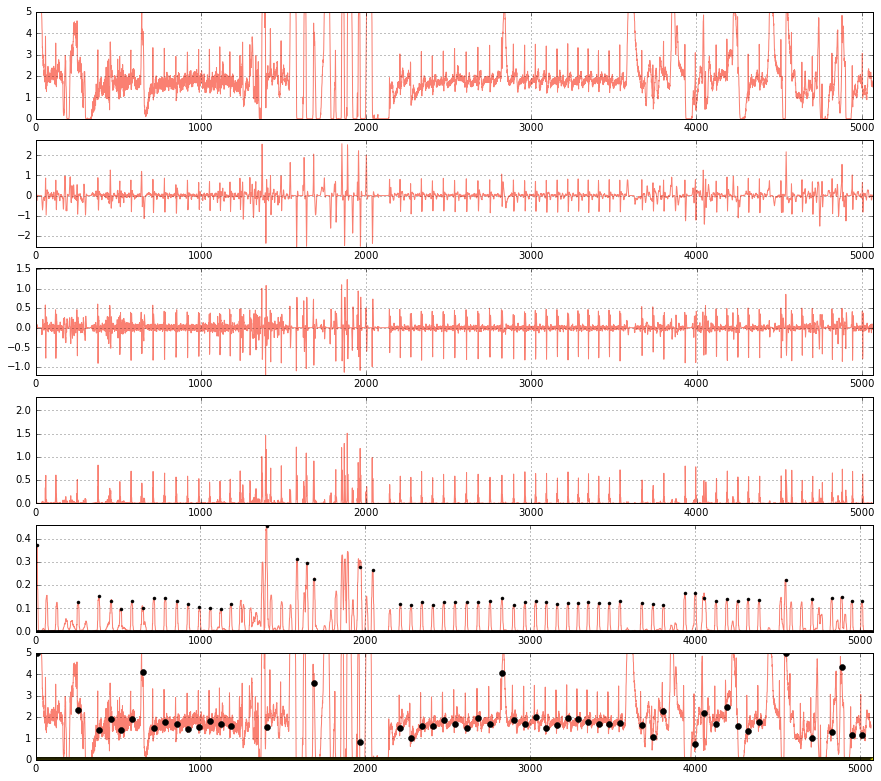

In [17]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse7.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 1649.0, 0.0, 5.0)

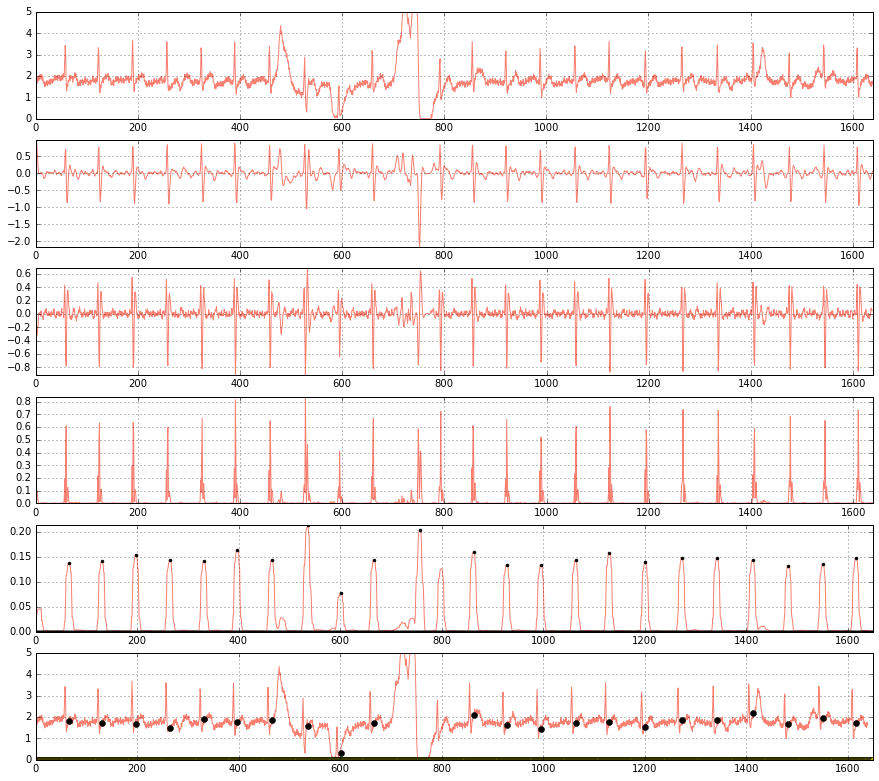

In [18]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse9.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 6721.0, 0.0, 5.0)

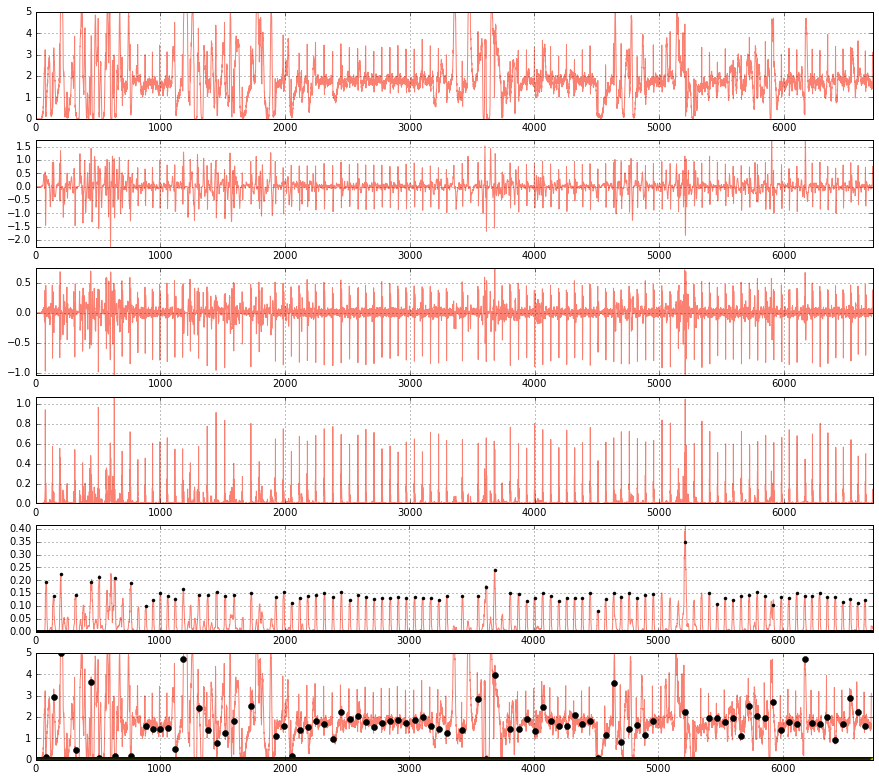

In [19]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse10.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


(0.0, 2656.0, 0.0, 5.0)

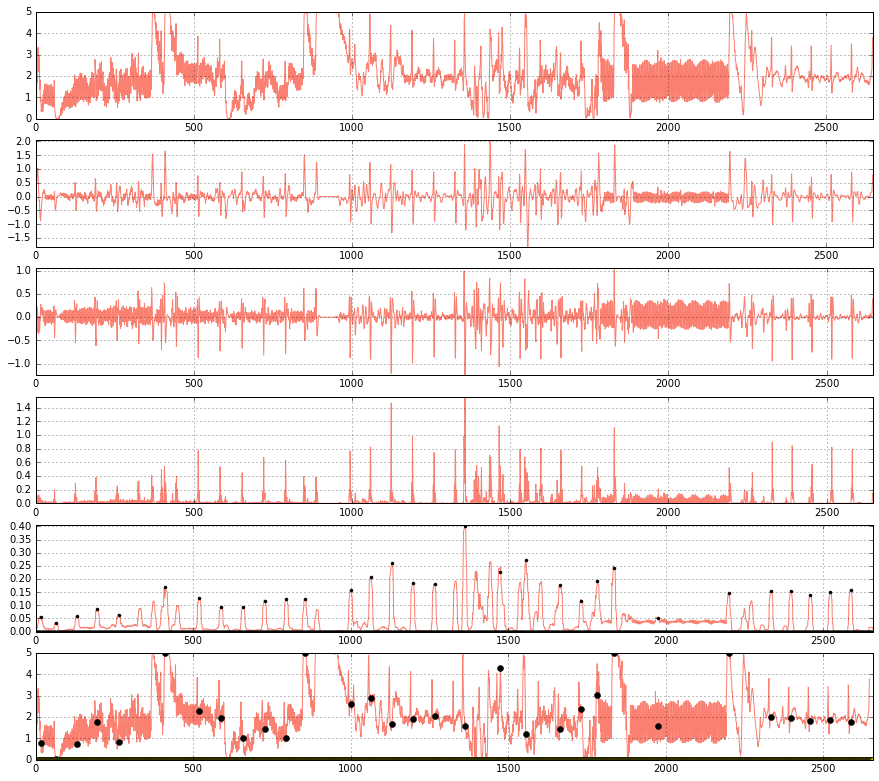

In [20]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse12.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [21]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse14.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


IOError: [Errno 2] No such file or directory: 'data/pulse14.csv'

In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse15.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse16.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse17.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse19.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse20.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")


In [ ]:
## Signal processing containers.
raw_signal = np.array([])
bandpass_signal = np.array([])
differentiated_signal = np.array([])
squared_signal = np.array([])
integrated_signal = np.array([])

## Signal filtering params.
signal_freq = 84.0
lowcut = 5.0
highcut = 15.0

## Detection.
fiducial_mark_idx = np.array([])
fiducial_mark_val = np.array([])
spki = 0.0 
npki = 0.0 
peaki = 0.0
threshold_1 = 0.0
threshold_2 = 0.0 
qrs_peak = np.array([])
noise_peak = np.array([])

peak_vals = np.array([])
spki_vals = np.array([])
npki_vals = np.array([])
threshold_1_vals = np.array([])
threshold_2_vals = np.array([])

## Load and clean data.
with open("data/pulse21.csv") as f:
    content = f.readlines()
raw_data = []
for line in content:
    raw_signal = np.append(raw_signal, float(line.rstrip().split(';')[1]))

## Signal filtering - pass band 5-15 Hz.
bandpass_signal = butter_bandpass_filter(raw_signal, lowcut, highcut, signal_freq, order=1)

## Derivative - provide QRS slope info - five point derivative with 1 sample delay.
differentiated_signal = np.diff(bandpass_signal)

## Squaring - signal is squared point by point.
squared_signal = np.power(differentiated_signal, 2)

## Moving-window integration - to obtain waveform feature information in addition to the slope.
## Time window should be of the length of longest possible QRS complex - 30 samples (150 ms) for 200 samples/s.
N = 12
integrated_signal = np.convolve(squared_signal, np.ones((N,))/N)

## Fiducial mark - peak detection.
peaks_indices = find_peaks_cwt(integrated_signal[:-1], np.arange(10, 15), noise_perc=0.1)

for peak_index in peaks_indices:
    fiducial_mark_idx = np.append(fiducial_mark_idx, peak_index)
    fiducial_mark_val = np.append(fiducial_mark_val, integrated_signal[peak_index])
    
fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val

## Thresholding detect peaks.
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    if peak_val > threshold_1:
        qrs_peak = np.append(qrs_peak, peak_idx)
        spki = 0.125 * peak_val + 0.875 * spki
#         print "pulse - peak: %f, spki: %f, threshold1: %f" % (peak_val, spki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    else:
        noise_peak = np.append(noise_peak, peak_idx)
        npki = 0.125 * peak_val + 0.875 * npki
#         print "noise - peak: %f, npki: %f, threshold1: %f" % (peak_val, npki, threshold_1)
        
        spki_vals = np.append(spki_vals, spki)
        npki_vals = np.append(npki_vals, npki)
        threshold_1_vals = np.append(threshold_1_vals, threshold_1)
        threshold_2_vals = np.append(threshold_2_vals, threshold_2)
    
    peak_vals = np.append(peak_vals, peak_val)
    threshold_1 = npki + 0.25 * (spki - npki)
    threshold_2 = 0.5 * threshold_1

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]

noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[peak] = raw_signal[peak]

## Plot everything.
plt.figure(figsize=(15,18))
plt.subplot(811)
plt.plot(raw_signal, label="Original signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(812)
plt.plot(bandpass_signal, label="Bandpass signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(813)
plt.plot(differentiated_signal, label="Differentiated signal", color="salmon")
plt.grid(True)
plt.axis("tight")

plt.subplot(814)
plt.plot(squared_signal, label="Squared signal", color="salmon")
plt.grid(True)
plt.axis("tight")

fiducial_mark_indication = [0] * len(integrated_signal)
for peak_idx, peak_val in zip(fiducial_mark_idx, fiducial_mark_val):
    fiducial_mark_indication[int(peak_idx)] = peak_val
plt.subplot(815)
plt.plot(integrated_signal, label="Integrated signal", color="salmon")
plt.plot(fiducial_mark_indication, 'k.')
plt.grid(True)
plt.axis("tight")

qrs_peak_indication = [0] * len(integrated_signal)
for peak in qrs_peak:
    qrs_peak_indication[int(peak)] = raw_signal[int(peak)]
noise_peak_indication = [0] * len(integrated_signal)
for peak in noise_peak:
    noise_peak_indication[int(peak)] = raw_signal[int(peak)]
plt.subplot(816)
plt.plot(raw_signal, label="Integrated signal", color="salmon")
plt.plot(qrs_peak_indication, 'ko')
plt.plot(noise_peak_indication, 'yo')
plt.grid(True)
plt.axis("tight")
